In [13]:
import os
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

In [14]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
image_size = 128
batch_size =32
epochs =150

In [7]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    r"C:\Users\vipul\food\nutrition\imagesdataset",
    image_size=(image_size, image_size),
    batch_size=batch_size,
    shuffle=True
)


Found 15018 files belonging to 38 classes.


In [15]:
class_names = dataset.class_names
print("Class names:", class_names)
print("Total batches:", len(dataset))

Class names: ['apple_pie', 'bread_pudding', 'carrot_cake', 'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'club_sandwich', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'eggs_benedict', 'fish_and_chips', 'french_fries', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'grilled_cheese_sandwich', 'hamburger', 'ice_cream', 'lasagna', 'lobster_bisque', 'omelette', 'onion_rings', 'pancakes', 'pizza', 'red_velvet_cake', 'risotto', 'samosa', 'spring_rolls', 'strawberry_shortcake', 'waffles']
Total batches: 470


In [9]:
len(dataset)

470

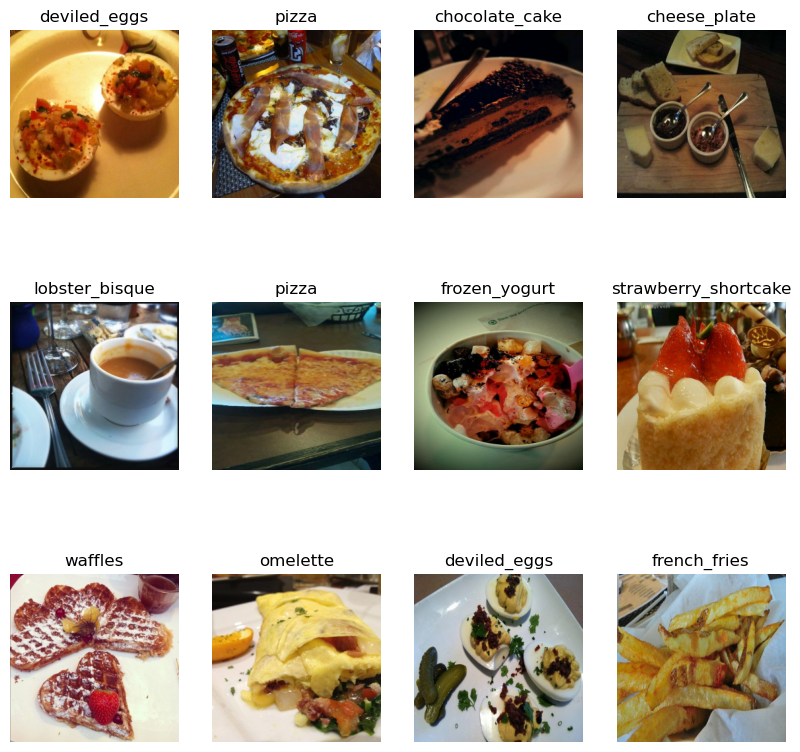

In [16]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [12]:
#80% => train
#20% => 10% - test , 10% - validate

In [17]:
def dataset_partitions_tf(ds, train_split=0.8, test_split=0.1, valid_split=0.1,
                          shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(ds_size * train_split)
    valid_size = int(ds_size * valid_split)

    train_ds = ds.take(train_size)
    test_ds = ds.skip(train_size).take(valid_size)
    valid_ds = ds.skip(train_size).skip(valid_size)
    return train_ds, test_ds, valid_ds


In [18]:
train_ds, test_ds, valid_ds = dataset_partitions_tf(dataset)
print(f"Train: {len(train_ds)}, Test: {len(test_ds)}, Validation: {len(valid_ds)}")

Train: 376, Test: 47, Validation: 47


In [19]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
valid_ds = valid_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [20]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(image_size, image_size),
    layers.Rescaling(1.0 / 255)
])

In [21]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
])

In [22]:
n_classes = len(class_names)

In [46]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(image_size, image_size, 3),
    include_top=False,
    weights="imagenet"
)

base_model.trainable = False  # freeze backbone

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(n_classes, activation="softmax")
])


C:\Users\vipul\AppData\Local\Temp\ipykernel_16864\2392372334.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


In [47]:
# Build model (correct input shape)
model.build(input_shape=(None, image_size, image_size, 3))

In [48]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 8, 8, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 38)             │        48,678 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,306,662 (8.80 MB)

 Trainable params: 48,678 (190.15 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [49]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

In [50]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=10,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.2,
        patience=5,
        min_lr=1e-6
    )
]

In [51]:
# Train
history = model.fit(
    train_ds,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=valid_ds,
    verbose=1,
    callbacks=callbacks
)

Epoch 1/150


376/376 ━━━━━━━━━━━━━━━━━━━━ 401s 1s/step - accuracy: 0.2027 - loss: 3.0806 - val_accuracy: 0.4973 - val_loss: 1.9618 - learning_rate: 5.0000e-04
Epoch 2/150
376/376 ━━━━━━━━━━━━━━━━━━━━ 521s 1s/step - accuracy: 0.3774 - loss: 2.2530 - val_accuracy: 0.5665 - val_loss: 1.6133 - learning_rate: 5.0000e-04
Epoch 3/150
376/376 ━━━━━━━━━━━━━━━━━━━━ 449s 1s/step - accuracy: 0.4373 - loss: 2.0151 - val_accuracy: 0.5898 - val_loss: 1.4826 - learning_rate: 5.0000e-04
Epoch 4/150
376/376 ━━━━━━━━━━━━━━━━━━━━ 416s 1s/step - accuracy: 0.4716 - loss: 1.8857 - val_accuracy: 0.6190 - val_loss: 1.3955 - learning_rate: 5.0000e-04
Epoch 5/150
376/376 ━━━━━━━━━━━━━━━━━━━━ 398s 1s/step - accuracy: 0.4935 - loss: 1.8138 - val_accuracy: 0.6370 - val_loss: 1.3368 - learning_rate: 5.0000e-04
Epoch 6/150
376/376 ━━━━━━━━━━━━━━━━━━━━ 234s 624ms/step - accuracy: 0.5066 - loss: 1.7620 - val_accuracy: 0.6469 - val_loss: 1.3082 - learning_rate: 5.0000e-04
Epoch 7/150
376/376 ━━━━━━━━━━━━━━━━━━━━ 251s 669ms/step - ac

In [52]:
scores = model.evaluate(test_ds)
print(f"Test Loss: {scores[0]:.4f}")
print(f"Test Accuracy: {scores[1]*100:.2f}%")

47/47 ━━━━━━━━━━━━━━━━━━━━ 28s 582ms/step - accuracy: 0.6915 - loss: 1.0611
Test Loss: 1.0611
Test Accuracy: 69.15%


In [53]:
model_version = 2
save_dir = "./saved_models"
os.makedirs(save_dir, exist_ok=True)
model_path = os.path.join(save_dir, f"{model_version}.keras")

model.save(model_path)
print(f"✅ Model saved at: {os.path.abspath(model_path)}")

✅ Model saved at: c:\Users\vipul\food\saved_models\2.keras


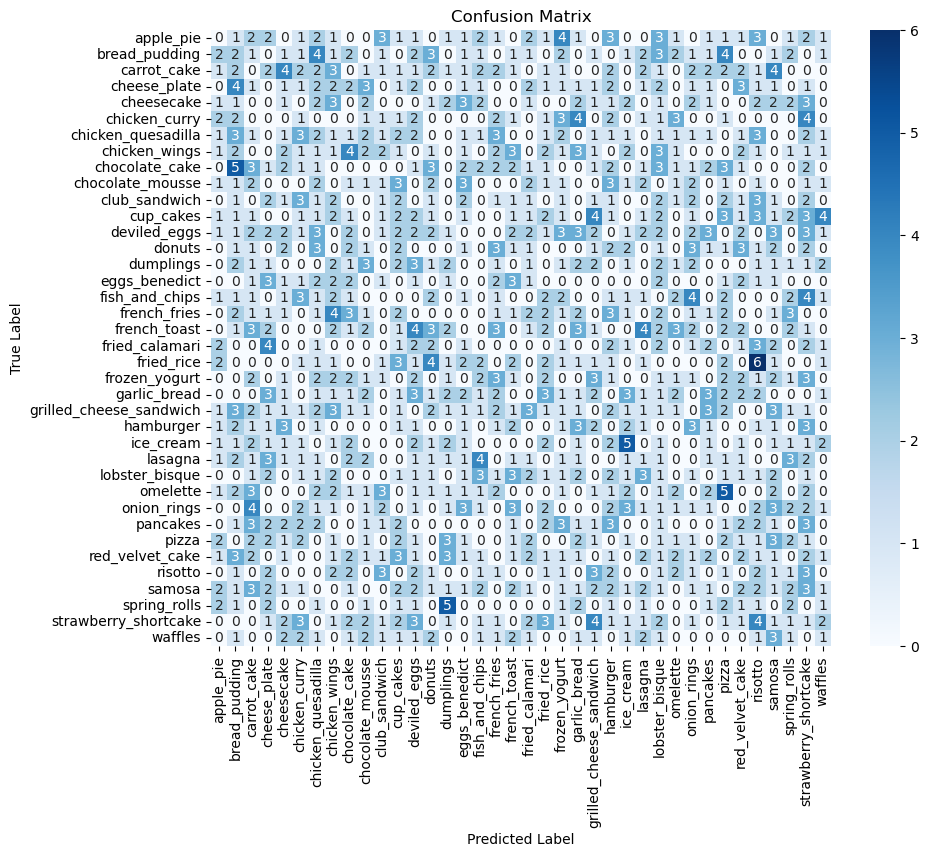

In [55]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

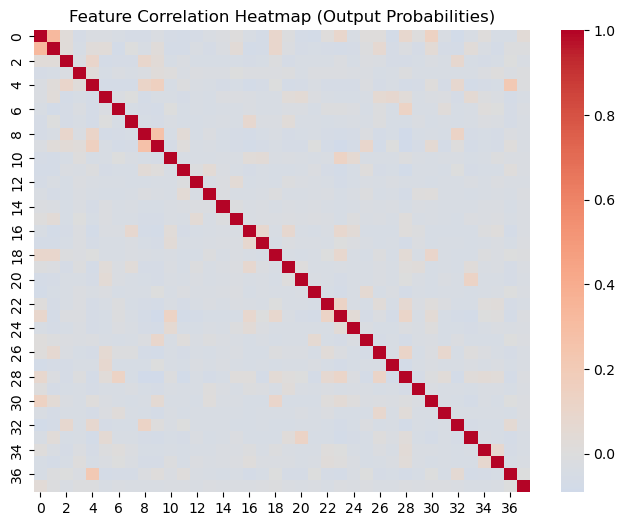

In [56]:
#Correlation Heatmap (Output Probabilities)

plt.figure(figsize=(8, 6))
sns.heatmap(np.corrcoef(y_pred_probs, rowvar=False), cmap="coolwarm", center=0)
plt.title("Feature Correlation Heatmap (Output Probabilities)")
plt.show()

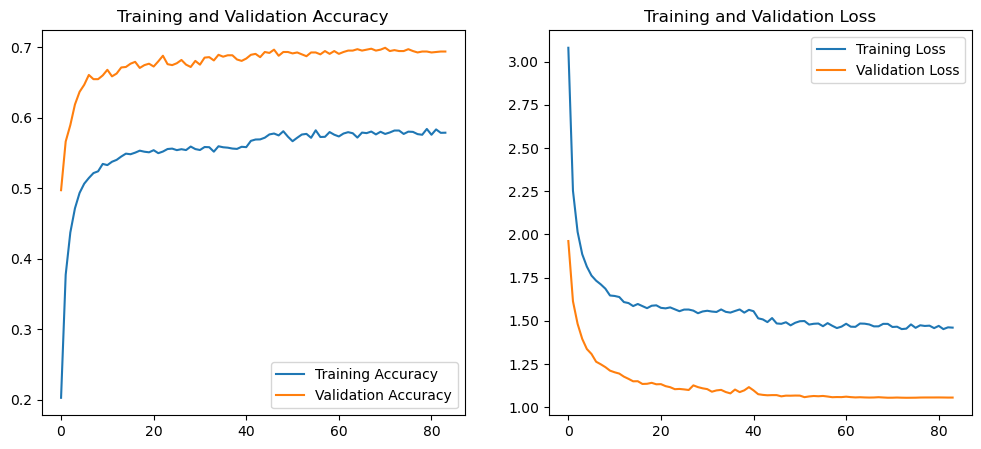

In [57]:
#Training and Validation Performance
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


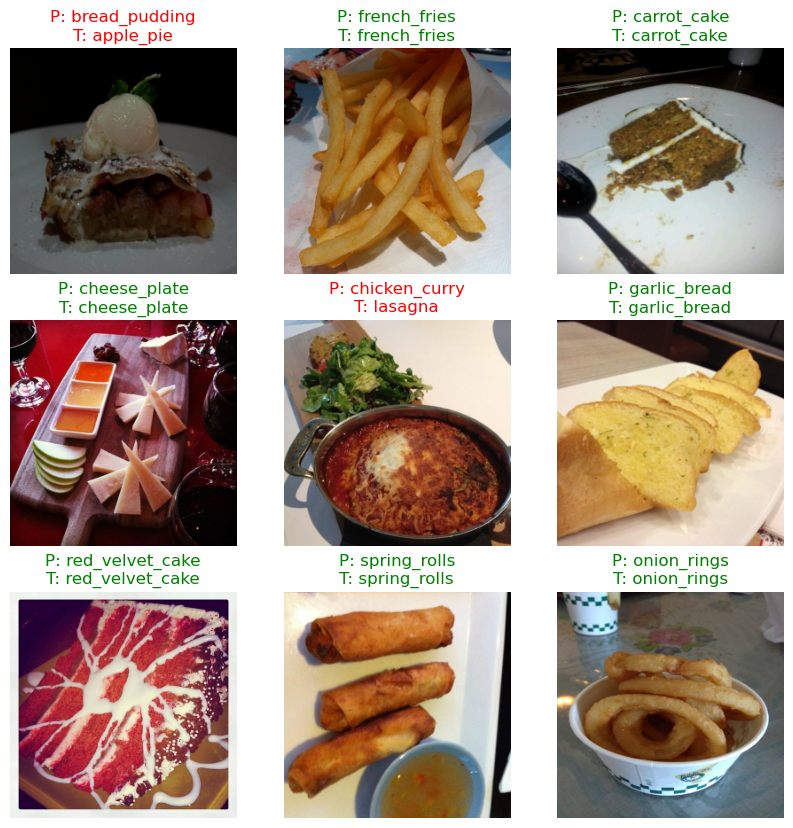

In [58]:
#Sample Predictions Visualization

plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):
    preds = model.predict(images)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        pred_label = class_names[np.argmax(preds[i])]
        true_label = class_names[labels[i]]
        color = "green" if pred_label == true_label else "red"
        plt.title(f"P: {pred_label}\nT: {true_label}", color=color)
        plt.axis("off")
plt.show()